In [1]:
#set adequate environment
import os
import sys
import theano
import keras
theano.config.gcc.cxxflags = '-march=corei7'

#load needed things
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from keras.layers import Input, Activation, Dense
#from keras.utils import np_utils
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
#from keras import backend as K
# Run classifier with cross-validation and plot ROC curves
#from itertools import cycle
#from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import LabelEncoder
#from scipy import interp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pyp
#import itertools
import math
import ROOT

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using Theano backend.


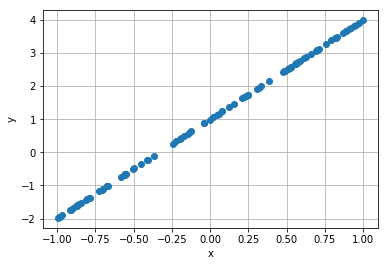

In [2]:
#produces the distribution to fit
w = 3
b = 1

rd = ROOT.TRandom()
X = []
Y = []
e = []
for i in range(100):
    e.append(0)
    ip = 1 - 2*rd.Rndm()
    X.append( ip )
    Y.append( b+w*ip )
    
#plot distribution
pyp.errorbar(X, Y, e, fmt='o')
pyp.xlabel('x')
pyp.ylabel('y')
pyp.grid(True)
pyp.show()

In [3]:
#plot Loss space
loss_name = 'mine'
lw = []
lb = []
lL = []

resolution = 50
lmin = 100000
wmin = 0
bmin = 0
s = 3
for iw in range(int(w-s),int(w+s)):
    for r1 in range(resolution):
        iiw = iw + r1/float(resolution)
        for ib in range(int(b-s),int(b+s)):
            for r2 in range(resolution):
                iib = ib + r2/float(resolution)
                for ix in range(len(X)):
                    y = Y[ix]
                    yl = iib+iiw*X[ix]
                    if(loss_name == "mae"):
                        il = math.fabs(y-yl)
                    if(loss_name == "mse"):
                        il = 0.5*pow(y-yl,2)
                    if(loss_name == "mine"):
                        il = math.sqrt(math.fabs((y-yl)/float(y+yl+0.00001)))
                    
                    lw.append( iiw )
                    lb.append( iib )
                    lL.append( il )
                    if(il < lmin):
                        lmin = il
                        wmin = iiw
                        bmin = iib
                    #print "p1: %.3f, p2: %.3f, L: %.3f" % (ip1,ip2,il)
print "wmin: %.2f, bmin: %.2f, Lmin: %.2f" % (wmin, bmin, lmin)

wmin: 3.00, bmin: 1.00, Lmin: 0.00


In [4]:
# updatable plot
from IPython.display import clear_output
from keras import backend as K
from matplotlib.colors import LogNorm

class Tscheduler(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        #self.val_losses = []
        self.accs = []
        #self.val_accs = []
        self.logs = []
        self.ws = []
        self.bs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        #self.val_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        #self.val_accs.append(logs.get('val_acc'))
        #getting the updated parameters
        for layer in model.layers:
            weights = layer.get_weights() # list of numpy arrays
            
        nw = weights[0][0]
        nb = weights[1][0]
        self.ws.append(nw)
        self.bs.append(nb)
        self.i += 1
        
        clear_output(wait=True)
        fig = pyp.figure()
        fig.set_figheight(6)
        fig.set_figwidth(15)
        pyp.rc("font", size=15)

        fig1 = fig.add_subplot(121)
        pyp.plot(self.x, self.losses, label="tloss: %f" % self.losses[len(self.losses)-1]) 
        #pyp.plot(self.x, self.val_losses, label="vloss: %f" % self.val_losses[len(self.val_losses)-1])
        pyp.xlabel('epochs')
        pyp.ylabel('Loss')
        pyp.legend()
        pyp.grid(True)
        
        fig2 = fig.add_subplot(122)
        pyp.plot(self.ws, self.bs, color='blue', label="w: %.2f, b: %.2f" % (self.ws[len(self.ws)-1],self.bs[len(self.bs)-1]))
        pyp.hist2d(lw, lb, bins=100, weights=lL, norm=LogNorm())
        pyp.xlabel("weight (exp= %.1f)" % w)
        pyp.ylabel("bias (exp= %.1f)" % b)
        p1 = [w]
        p2 = [b]
        e = [0]
        pyp.errorbar(p1, p2, e, fmt='o', color='red')
        pyp.colorbar()
        pyp.title('Parameters finding evolution')
        pyp.legend()
        #pyp.grid(True)

        pyp.tight_layout()
        fig = pyp.show()

                
            
Tschedule = Tscheduler()

In [5]:
def mine(y_true, y_pred):
    return K.sqrt(K.abs((y_true-y_pred)/(y_true+y_pred+0.00001)))

loss_name = mine

In [11]:
#A NN of just one neuron
model = Sequential()
model.add(Dense(1, input_dim=1, kernel_initializer='uniform', activation='linear'))
model.compile(loss=loss_name, optimizer='adam')
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None


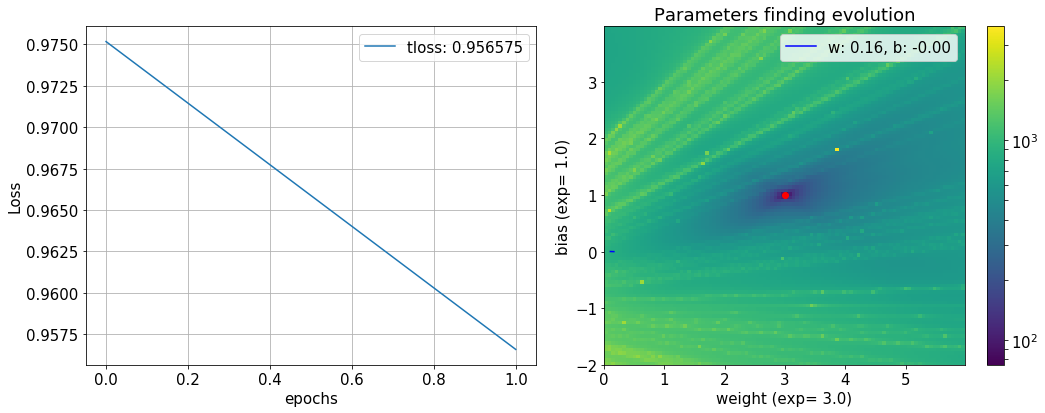

In [ ]:
history1 = model.fit(X, Y, epochs=50, batch_size=1, verbose=0, callbacks=[Tschedule])